# Daniel Arruda Ponte - 121048284

# Bibliotecas

In [ ]:
# !pip install optuna
# !pip install scikit-posthocs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import math
import imageio
import os
import pandas as pd
import traceback

import json
import scipy
from collections import defaultdict

# import optuna

import scikit_posthocs as sp
from scipy import stats

# Gráficos

In [ ]:
def plot_population_path_3d_gif(
    surface_bounds,
    f,
    population_samples,
    evaluations,
    title="Evolução da População",
    gif_name="population_evolution.gif"
):
    a1, b1 = surface_bounds[0]
    a2, b2 = surface_bounds[1]

    x = np.linspace(a1, b1, 100)
    y = np.linspace(a2, b2, 100)
    X, Y = np.meshgrid(x, y)
    Z = f((X, Y))

    temp_dir = "temp_frames"
    os.makedirs(temp_dir, exist_ok=True)
    images = []

    n_generations = len(population_samples)

    for gen_idx in range(n_generations):
        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection='3d')

        ax.set_title(f"{title} - Geração {gen_idx + 1} - Avaliação: {evaluations[gen_idx][0]:.4f}")

        ax.view_init(elev=15, azim=-300)
        surface = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.7)
        fig.colorbar(surface, shrink=0.5, aspect=10)

        population = population_samples[gen_idx]
        for i, point in enumerate(population):
            x, y = point
            z = f((x, y))
            ax.scatter(x, y, z, color='r', s=20)

        best_idx = np.argmin([f(p) for p in population])
        best_point = population[best_idx]
        ax.scatter(*best_point, f(best_point), color='blue', s=50, label='Melhor ponto')

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('f(x, y)')
        ax.legend()
        plt.tight_layout()

        frame_path = os.path.join(temp_dir, f"frame_{gen_idx:03d}.png")
        plt.savefig(frame_path, dpi=150)
        plt.close()
        images.append(imageio.imread(frame_path))

    imageio.mimsave(gif_name, images, fps=3)

    for file in os.listdir(temp_dir):
        os.remove(os.path.join(temp_dir, file))
    os.rmdir(temp_dir)

In [ ]:
def plot_population_path_3d_pngs(
    surface_bounds,
    f,
    population_samples,
    evaluations,
    evaluations_counts,
    title="Evolução da População",
    output_dir="populacao_frames",
    start_gen=0,
    end_gen=None,
    stepsize=1
):
    a1, b1 = surface_bounds[0]
    a2, b2 = surface_bounds[1]

    x = np.linspace(a1, b1, 100)
    y = np.linspace(a2, b2, 100)
    X, Y = np.meshgrid(x, y)
    Z = f((X, Y))

    os.makedirs(output_dir, exist_ok=True)

    total_generations = len(population_samples)

    if end_gen is None:
        end_gen = total_generations

    for gen_idx in range(start_gen, min(end_gen, total_generations), stepsize):
        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection='3d')

        # Título com geração, avaliação e quantidade de avaliações
        ax.set_title(
            f"{title} - Geração {gen_idx + 1} | Melhor avaliação: {evaluations[gen_idx][0]:.4f} | Quantidade de avaliações: {evaluations_counts[gen_idx]}"
        )

        ax.view_init(elev=15, azim=-300)
        surface = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.7)
        fig.colorbar(surface, shrink=0.5, aspect=10)

        population = population_samples[gen_idx]
        for point in population:
            x, y = point
            z = f((x, y))
            ax.scatter(x, y, z, color='r', s=20)

        # Destacar o melhor ponto
        best_idx = np.argmin([f(p) for p in population])
        best_point = population[best_idx]
        ax.scatter(*best_point, f(best_point), color='blue', s=50, label='Melhor ponto')

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('f(x, y)')
        ax.legend()
        plt.tight_layout()

        output_path = os.path.join(output_dir, f"geracao_{gen_idx}.png")
        plt.savefig(output_path, dpi=150)
        plt.close()

In [ ]:
def plot_population_contour_lines_pngs(
    surface_bounds,
    f,
    population_samples,
    evaluations,
    evaluations_counts,
    title="Evolução da População (2D - Linhas)",
    output_dir="contour_line_frames",
    start_gen=0,
    end_gen=None,
    stepsize=1
):
    a1, b1 = surface_bounds[0]
    a2, b2 = surface_bounds[1]

    x = np.linspace(a1, b1, 200)
    y = np.linspace(a2, b2, 200)
    X, Y = np.meshgrid(x, y)
    Z = f((X, Y))

    os.makedirs(output_dir, exist_ok=True)

    total_generations = len(population_samples)
    if end_gen is None:
        end_gen = total_generations

    for gen_idx in range(start_gen, min(end_gen, total_generations), stepsize):
        fig, ax = plt.subplots(figsize=(10, 8))

        ax.set_title(
            f"{title} - Geração {gen_idx + 1} | Melhor avaliação: {evaluations[gen_idx][0]:.4f} | Quantidade de avaliações: {evaluations_counts[gen_idx]}"
        )

        # Curvas de nível apenas com linhas
        contours = ax.contour(X, Y, Z, levels=150, cmap='viridis')
        fig.colorbar(contours, shrink=0.5, aspect=10)

        population = population_samples[gen_idx]
        for point in population:
            x, y = point
            ax.plot(x, y, 'ro', markersize=4)

        # Melhor ponto da geração
        best_idx = np.argmin([f(p) for p in population])
        best_point = population[best_idx]
        ax.plot(*best_point, 'bo', markersize=8, label='Melhor ponto')

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.legend()
        plt.tight_layout()

        output_path = os.path.join(output_dir, f"geracao_{gen_idx}.png")
        plt.savefig(output_path, dpi=150, facecolor='white')
        plt.close()

In [ ]:
def plot_path_fx(f_min, f_values, title, file_name):
  iterations = list(range(len(f_values)))

  plt.plot(iterations, f_values, marker='o', label='f(x)')
  plt.axhline(y=f_min, color='r', linestyle='--', label=f'Valor ótimo f(x*) = {f_min}')
  plt.title(f'{title}')
  plt.xlabel('Geração')
  plt.ylabel('f(x)')
  plt.grid(True)
  plt.legend()

  plt.savefig(f'{file_name}.png', dpi=300, bbox_inches='tight')

  plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

def plot_multiple_convergence_curves(curves_dict, f_min=None, title="Curvas de Convergência",
                                     file_name="convergencia", zoom_range=(5, 13), zoom_ylim=None,
                                     mode="both", max_generation=None):
    """
    Plota curvas de convergência com opções de zoom.

    Parâmetros:
    - curves_dict: dicionário com nome da curva como chave e lista de valores f(x) como valor.
    - f_min: valor ótimo conhecido (opcional).
    - title: título do gráfico.
    - file_name: nome do arquivo PNG (sem extensão).
    - zoom_range: tupla com (x_min, x_max) para o zoom no eixo das gerações.
    - zoom_ylim: tupla com (y_min, y_max) para o zoom no eixo de f(x) (opcional).
    - mode: 'full' para gráfico completo sem zoom,
            'both' para gráfico com zoom ao lado,
            'zoom' para mostrar apenas a área de zoom.
    - max_generation: número máximo de gerações (iterações) a exibir (opcional).
    """
    if mode not in ["full", "both", "zoom"]:
        raise ValueError("Modo inválido. Use 'full', 'both' ou 'zoom'.")

    # Determina o menor número de gerações entre todas as curvas, se max_generation não for informado
    if max_generation is None:
        max_generation = min(len(values) for values in curves_dict.values())

    fig, ax = plt.subplots(figsize=(10, 6))
    target_ax = ax

    if mode == "zoom":
        x_min, x_max = zoom_range
        x_max = min(x_max, max_generation - 1)  # Garante que não ultrapasse o limite real

        for label, f_values in curves_dict.items():
            values = f_values[:max_generation]
            zoom_iterations = list(range(x_min, x_max + 1))
            zoom_values = values[x_min:x_max + 1]
            target_ax.plot(zoom_iterations, zoom_values, label=label)

        target_ax.set_xlim(x_min, x_max)
        if zoom_ylim:
            target_ax.set_ylim(zoom_ylim)

    else:
        for label, f_values in curves_dict.items():
            values = f_values[:max_generation]
            iterations = list(range(len(values)))
            target_ax.plot(iterations, values, label=label)

        if f_min is not None:
            ax.axhline(y=f_min, color='r', linestyle='--', label=f'Valor ótimo f(x*) = {f_min}')

    target_ax.set_xlabel('Geração')
    target_ax.set_ylabel('f(x)')
    target_ax.grid(True)
    target_ax.set_title(title if mode != "zoom" else f"{title} (zoom no cotovelo)")
    target_ax.legend(loc="best")

    if mode == "both":
        axins = inset_axes(ax, width="50%", height="50%", loc='upper right')
        x_min, x_max = zoom_range
        x_max = min(x_max, max_generation - 1)

        for label, f_values in curves_dict.items():
            values = f_values[:max_generation]
            zoom_iterations = list(range(x_min, x_max + 1))
            zoom_values = values[x_min:x_max + 1]
            axins.plot(zoom_iterations, zoom_values, label=label)

        axins.set_xlim(x_min, x_max)
        if zoom_ylim:
            axins.set_ylim(zoom_ylim)
        axins.grid(True)
        axins.legend(fontsize=10)
        mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

    plt.tight_layout()
    plt.savefig(f"{file_name}.png", dpi=300)  # <-- Salva o gráfico como imagem PNG
    plt.show()

In [ ]:
def plot_boxplot_evaluations(experiment_data, title="Distribuição das Avaliações Finais", file_name="boxplot_avaliacoes"):
    experiment_names = list(experiment_data.keys())
    evaluations_data = list(experiment_data.values())

    # Paleta de cores (ajuste conforme o número de experimentos)
    colors = ['skyblue', 'lightgreen', 'salmon', 'plum', 'khaki', 'lightcoral', 'mediumaquamarine']

    plt.figure(figsize=(16, 6))
    box = plt.boxplot(evaluations_data, labels=experiment_names, patch_artist=True)

    # Aplica as cores em cada boxplot
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    plt.title(title)
    plt.xlabel("Tipo de Experimento")
    plt.ylabel("Avaliação Final de f(x)")
    plt.grid(True, axis='y')
    plt.tight_layout()

    plt.savefig(f'{file_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Função objetivo

In [ ]:
def gerar_rosenbrock(d):
  def rosenbrock(X):
    f = 0

    for i in range(d - 1):
      f += 100 * (X[i + 1] - X[i]**2)**2 + (X[i] - 1)**2

    return f

  return rosenbrock

def gerar_rastrigin(d):
  def rastrigin(X):
    f = 10 * d

    for x in X:
      f += x**2 - 10 * np.cos(2 * np.pi * x)

    return f

  return rastrigin

def select_interval(option):
  if option.lower() == 'Sphere':
    return (-5.12, 5.12)
  elif option.lower() == 'Rastrigin':
    return (-5.12, 5.12)
  elif option.lower() == 'Griewank':
    return (-600, 600)
  elif option.lower() == 'Ackley':
    return (-32.768, 32.768)
  elif option.lower() == 'Rosenbrock':
    return (-2.48, 2.48)
  else:
    raise ValueError("Invalid function name. Choose from 'Sphere', 'Rastrigin', 'Griewank', 'Ackley' or Rosenbrock.")

# Implementação

## C-DEEPSO

In [ ]:
class C_DEEPSO:
  def __init__(self, funcao, dimensao,
               tamanho_populacao, w_i, w_a, w_c, k_mem, p_com, t_mut, x_faixa, Cr,
               estrategia_DE='DE/rand/1', estrategia_vetor_amostrado='Sg',
               beta=0.5,
               max_avaliacoes=1000):

    self.funcao = funcao
    self.dimensao = dimensao
    self.tamanho_populacao = tamanho_populacao
    self.w_i = w_i
    self.w_a = w_a
    self.w_c = w_c
    self.k_mem = k_mem
    self.p_com = p_com
    self.t_mut = t_mut
    self.x_faixa = x_faixa
    self.Cr = Cr

    self.estrategia_DE = estrategia_DE
    self.estrategia_vetor_amostrado = estrategia_vetor_amostrado

    self.beta = beta

    self.max_avaliacoes = max_avaliacoes

  def gerar_populacao(self):
    x_min, x_max = self.x_faixa
    populacao = x_min + (x_max - x_min) * np.random.uniform(low=0, high=1, size=(self.tamanho_populacao, self.dimensao))

    return populacao

  def gerar_velocidade_inicial(self):
    v_max = (self.x_faixa[1] - self.x_faixa[0]) * np.random.uniform(low=0, high=1, size=(self.tamanho_populacao, self.dimensao))
    v_min = -v_max

    velocidades = v_min + (v_max - v_min) * np.random.uniform(low=0, high=1, size=(self.tamanho_populacao, self.dimensao))

    return velocidades

  def avaliar(self, x):
    return self.funcao(x)

  def avaliacao(self, populacao, quant_avaliacoes):
    if quant_avaliacoes >= self.max_avaliacoes:
      raise Exception("Número máximo de avaliações excedido")

    if quant_avaliacoes + len(populacao) > self.max_avaliacoes:
      populacao = populacao[:self.max_avaliacoes - quant_avaliacoes]

    return populacao, np.apply_along_axis(self.avaliar, 1, populacao)

  def mutacao_DE(self, populacao, i, best):
    indices = np.arange(self.tamanho_populacao)
    indices = indices[indices != i]
    np.random.shuffle(indices)

    if self.estrategia_DE == "DE/rand/1":
      x1, x2, x3 = populacao[indices[:3]]
      return x1 + self.beta * (x2 - x3)

    elif self.estrategia_DE == "DE/rand/2":
      x1, x2, x3, x4, x5 = populacao[indices[:5]]
      return x1 + self.beta * (x2 - x3 + x4 - x5)

    elif self.estrategia_DE == "DE/best/1":
      x2, x3 = populacao[indices[:2]]
      return best + self.beta * (x2 - x3)

    elif self.estrategia_DE == "DE/best/2":
      x2, x3, x4, x5 = populacao[indices[:4]]
      return best + self.beta * (x2 - x3 + x4 - x5)

    elif self.estrategia_DE == "DE/current-to-best/1":
      xi = populacao[i]
      x2, x3 = populacao[indices[:2]]
      return xi + self.beta * (best - xi + x2 - x3)

    elif self.estrategia_DE == "DE/current-to-best/2":
      xi = populacao[i]
      x2, x3, x4, x5 = populacao[indices[:4]]
      return xi + self.beta * (best - xi + x2 - x3 + x4 - x5)

    else:
      raise ValueError(f"Estratégia de mutação desconhecida: {self.estrategia_DE}")

  def gerar_vetor_trial(self, individuo, mutante):
    vetor_trial = np.zeros(self.dimensao)

    for i in range(self.dimensao):
      vetor_trial[i] = individuo[i] if self.Cr >= np.random.rand() else mutante[i]

    return vetor_trial

  def amostragem_vetor(self,
                       populacao,
                       avaliacoes,
                       memoria_coletiva,
                       memoria_coletiva_avaliacoes,
                       quant_avaliacoes):

    if self.estrategia_vetor_amostrado == "Sg":
      indice = np.random.choice(len(populacao))

      return (populacao[indice], avaliacoes[indice]), quant_avaliacoes

    elif self.estrategia_vetor_amostrado == "Sg-rand":
      indices = np.random.choice(len(populacao), size=self.dimensao, replace=True)

      x_r = np.array([populacao[indices[i], i] for i in range(self.dimensao)])
      x_r_avaliacao = self.avaliar(x_r)

      quant_avaliacoes += 1

      return (x_r, x_r_avaliacao), quant_avaliacoes

    elif self.estrategia_vetor_amostrado == "Pb":
      indice = np.random.choice(len(memoria_coletiva))

      return (memoria_coletiva[indice], memoria_coletiva_avaliacoes[indice]), quant_avaliacoes

    elif self.estrategia_vetor_amostrado == "Pb-rand":
      indices = np.random.choice(len(memoria_coletiva), size=self.dimensao, replace=True)

      x_r = np.array([memoria_coletiva[indices[i], i] for i in range(self.dimensao)])
      x_r_avaliacao = self.avaliar(x_r)

      quant_avaliacoes += 1

      return (x_r, x_r_avaliacao), quant_avaliacoes

    elif self.estrategia_vetor_amostrado == "SgPb-rand":
      escolha_vetor = np.random.choice([0, 1], size=self.dimensao, p=[0.5, 0.5])

      indices_populacao = np.random.randint(0, len(populacao), size=self.dimensao)
      indices_memoria = np.random.randint(0, len(memoria_coletiva), size=self.dimensao)

      x_r = np.where(
          escolha_vetor == 0,
          populacao[indices_populacao, np.arange(self.dimensao)],
          memoria_coletiva[indices_memoria, np.arange(self.dimensao)]
      )

      x_r_avaliacao = self.avaliar(x_r)

      quant_avaliacoes += 1

      return (x_r, x_r_avaliacao), quant_avaliacoes

    else:
      raise ValueError(f"Estratégia de amostragem desconhecida: {self.estrategia_vetor_amostrado}")

  def calcular_macrogradiente(self, x_st_avaliacao, x_i_avaliacao):
    return 1 if x_st_avaliacao < x_i_avaliacao else -1

  def mutacao_peso(self, peso):
    return peso + self.t_mut * np.random.normal(loc=0, scale=1)

  def mutacao_melhor(self, melhor):
    return melhor * (1 + self.t_mut * np.random.normal(loc=0, scale=1))

  def calcular_matriz_de_comunicacao(self):
    diagonal = np.random.choice([0, 1], size=self.dimensao, p=[1 - self.p_com, self.p_com])

    return diagonal

  def run(self):
    populacao = self.gerar_populacao()
    velocidades = self.gerar_velocidade_inicial()

    quant_avaliacoes = 0

    trace_populacoes = []
    trace_avaliacoes = []
    trace_num_avaliacoes = []

    try:
      populacao, avaliacoes = self.avaliacao(populacao, quant_avaliacoes)
      quant_avaliacoes += len(populacao)

      melhor = populacao[np.argmin(avaliacoes)]
      melhor_avaliacao = np.min(avaliacoes)

      indices_memoria_coletiva = np.argsort(avaliacoes)[:self.k_mem]

      memoria_coletiva = populacao[indices_memoria_coletiva]
      memoria_coletiva_avaliacoes = avaliacoes[indices_memoria_coletiva]

      while quant_avaliacoes < self.max_avaliacoes:
        matriz_de_comunicacao = self.calcular_matriz_de_comunicacao()

        for i in range(self.tamanho_populacao):
          x_DE = self.mutacao_DE(populacao, i, melhor)
          x_DE = self.gerar_vetor_trial(populacao[i], x_DE)
          x_DE_avaliacao = self.avaliar(x_DE)

          quant_avaliacoes += 1

          (x_r, x_r_avaliacao), quant_avaliacoes = self.amostragem_vetor(
              populacao,
              avaliacoes,
              memoria_coletiva,
              memoria_coletiva_avaliacoes,
              quant_avaliacoes
          )

          x_st = x_DE if x_DE_avaliacao < x_r_avaliacao else x_r
          x_st_avaliacao = x_DE_avaliacao if x_DE_avaliacao < x_r_avaliacao else x_r_avaliacao

          macrogradiente = self.calcular_macrogradiente(x_st_avaliacao, avaliacoes[i])

          w_i_mutado = self.mutacao_peso(self.w_i)
          w_a_mutado = self.mutacao_peso(self.w_a)
          w_c_mutado = self.mutacao_peso(self.w_c)

          melhor_mutado = self.mutacao_melhor(melhor)

          velocidade_temp = w_i_mutado * velocidades[i] + \
                            w_a_mutado * macrogradiente * (x_st - populacao[i]) + \
                            w_c_mutado * matriz_de_comunicacao * (melhor_mutado - populacao[i])

          x_temp = populacao[i] + velocidade_temp
          x_temp = np.clip(x_temp, self.x_faixa[0], self.x_faixa[1])

          avaliacao_x_temp = self.avaliar(x_temp)

          quant_avaliacoes += 1

          if avaliacoes[i] > avaliacao_x_temp:
            populacao[i] = x_temp
            avaliacoes[i] = avaliacao_x_temp

        memoria_concatenada = np.concatenate((populacao, memoria_coletiva))
        avaliacoes_concatenadas = np.concatenate((avaliacoes, memoria_coletiva_avaliacoes))

        indices_memoria_concatenada = np.argsort(avaliacoes_concatenadas)[:self.k_mem]

        memoria_coletiva = memoria_concatenada[indices_memoria_concatenada]
        memoria_coletiva_avaliacoes = avaliacoes_concatenadas[indices_memoria_concatenada]

        melhor_indice = np.argmin(avaliacoes)
        melhor = populacao[melhor_indice]
        melhor_avaliacao = avaliacoes[melhor_indice]

        indices_populacao_ordenados = np.argsort(avaliacoes)
        populacao = populacao[indices_populacao_ordenados]
        avaliacoes = avaliacoes[indices_populacao_ordenados]

        trace_populacoes.append(populacao.copy())
        trace_avaliacoes.append(avaliacoes.copy())
        trace_num_avaliacoes.append(quant_avaliacoes)

    except Exception as e:
      print(e)

    return trace_populacoes, trace_avaliacoes, trace_num_avaliacoes

## PSO

In [ ]:
class Nuvem_de_Particulas:
  def __init__(self, funcao, dimensao, faixa, tamanho_populacao, max_avaliacoes=1000, c1=2, c2=2, w=0.7):
    self.funcao = funcao
    self.dimensao = dimensao
    self.faixa_min, self.faixa_max = faixa
    self.max_avaliacoes = max_avaliacoes

    self.c1 = c1
    self.c2 = c2
    self.w = w

    self.tamanho_populacao = tamanho_populacao

  def gerar_populacao(self):
    return np.random.uniform(self.faixa_min, self.faixa_max, size=(self.tamanho_populacao, self.dimensao))

  def avaliar(self, x):
    return self.funcao(x)

  def avaliacao(self, populacao, quant_avaliacoes):
    if quant_avaliacoes >= self.max_avaliacoes:
      raise Exception("Número máximo de avaliações excedido")

    if quant_avaliacoes + len(populacao) > self.max_avaliacoes:
      populacao = populacao[:self.max_avaliacoes - quant_avaliacoes]

    return populacao, np.apply_along_axis(self.avaliar, 1, populacao)

  def run(self):
    populacao = self.gerar_populacao()
    quant_avaliacoes = 0

    trace_populacoes = []
    trace_avaliacoes = []
    trace_num_avaliacoes = []

    avaliacoes = np.apply_along_axis(self.avaliar, 1, populacao)
    quant_avaliacoes += self.tamanho_populacao

    populacao_melhores = populacao.copy()
    avaliacoes_melhores = avaliacoes.copy()

    melhor_global_indice = np.argmin(avaliacoes)
    melhor_global = populacao[melhor_global_indice].copy()
    melhor_global_avaliacao = avaliacoes[melhor_global_indice]

    velocidades = np.zeros((self.tamanho_populacao, self.dimensao))

    try:
      while quant_avaliacoes < self.max_avaliacoes:

        for i in range(self.tamanho_populacao):
            r1 = np.random.rand(self.dimensao)
            r2 = np.random.rand(self.dimensao)

            velocidades[i] = (self.w * velocidades[i] +
                              self.c1 * r1 * (populacao_melhores[i] - populacao[i]) +
                              self.c2 * r2 * (melhor_global - populacao[i]))

            populacao[i] += velocidades[i]

            populacao[i] = np.clip(populacao[i], self.faixa_min, self.faixa_max)

        avaliacoes = np.apply_along_axis(self.avaliar, 1, populacao)
        quant_avaliacoes += self.tamanho_populacao

        for i in range(self.tamanho_populacao):
            if avaliacoes[i] < avaliacoes_melhores[i]:
                avaliacoes_melhores[i] = avaliacoes[i]
                populacao_melhores[i] = populacao[i].copy()

                if avaliacoes_melhores[i] < melhor_global_avaliacao:
                    melhor_global_avaliacao = avaliacoes_melhores[i]
                    melhor_global = populacao_melhores[i].copy()

        indice_melhores = np.argsort(avaliacoes_melhores)

        populacao_melhores = populacao_melhores[indice_melhores]
        avaliacoes_melhores = avaliacoes_melhores[indice_melhores]
        populacao = populacao[indice_melhores]
        avaliacoes = avaliacoes[indice_melhores]

        velocidades = velocidades[indice_melhores]

        trace_populacoes.append(populacao_melhores.copy())
        trace_avaliacoes.append(avaliacoes_melhores.copy())
        trace_num_avaliacoes.append(quant_avaliacoes)

    except Exception as e:
      print(e)

    return trace_populacoes, trace_avaliacoes, trace_num_avaliacoes

## DE

In [ ]:
class Evolucao_Diferencial:
  def __init__(self, dimensao, faixa, funcao, max_avaliacoes, NP, F, Cr, estrategia="DE/rand/1/bin"):

      self.dimensao = dimensao
      self.faixa = faixa
      self.funcao = funcao
      self.max_avaliacoes = max_avaliacoes

      self.NP = NP
      self.F = F
      self.Cr = Cr
      self.estrategia = estrategia

  def gerar_populacao(self):
    return np.random.uniform(self.faixa[0], self.faixa[1], size=(self.NP, self.dimensao))

  def avaliar(self, x, quant_avaliacoes):
    if quant_avaliacoes >= self.max_avaliacoes:
      raise Exception("Número máximo de avaliações excedido")

    return self.funcao(x)

  def avaliacao(self, populacao, quant_avaliacoes):
    if quant_avaliacoes >= self.max_avaliacoes:
      raise Exception("Número máximo de avaliações excedido")

    if quant_avaliacoes + len(populacao) > self.max_avaliacoes:
      populacao = populacao[:self.max_avaliacoes - quant_avaliacoes]

    return populacao, np.apply_along_axis(self.funcao, 1, populacao)

  def ordenar_populacao(self, populacao, avaliacoes):
    indices = np.argsort(avaliacoes)

    return populacao[indices], avaliacoes[indices]

  def gerar_vetor_mutante(self, populacao, i, best_indice):
    estrategia_k = {
        "DE/rand/1/bin": 3,
        "DE/rand/2/bin": 5,
        "DE/best/1/bin": 2,
        "DE/best/2/bin": 4,
        "DE/current-to-best/1/bin": 2,
        "DE/current-to-best/2/bin": 4,
    }

    k = estrategia_k.get(self.estrategia, None)
    if k is None:
        raise ValueError(f"Estratégia de mutação desconhecida: {self.estrategia}")

    indices_possiveis = np.delete(np.arange(self.NP), i)

    if len(indices_possiveis) < k:
        replace_flag = True
    else:
        replace_flag = False

    indices = np.random.choice(indices_possiveis, size=k, replace=replace_flag)

    if self.estrategia == "DE/rand/1/bin":
        x1, x2, x3 = populacao[indices]
        return x1 + self.F * (x2 - x3)

    elif self.estrategia == "DE/rand/2/bin":
        x1, x2, x3, x4, x5 = populacao[indices]
        return x1 + self.F * (x2 - x3 + x4 - x5)

    elif self.estrategia == "DE/best/1/bin":
        best = populacao[best_indice]
        x2, x3 = populacao[indices]
        return best + self.F * (x2 - x3)

    elif self.estrategia == "DE/best/2/bin":
        best = populacao[best_indice]
        x2, x3, x4, x5 = populacao[indices]
        return best + self.F * (x2 - x3 + x4 - x5)

    elif self.estrategia == "DE/current-to-best/1/bin":
        best = populacao[best_indice]
        xi = populacao[i]
        x2, x3 = populacao[indices]
        return xi + self.F * (best - xi + x2 - x3)

    elif self.estrategia == "DE/current-to-best/2/bin":
        best = populacao[best_indice]
        xi = populacao[i]
        x2, x3, x4, x5 = populacao[indices]
        return xi + self.F * (best - xi + x2 - x3 + x4 - x5)

  def gerar_vetor_trial(self, individuo, mutante):
    vetor_trial = np.zeros(self.dimensao)

    for i in range(self.dimensao):
      vetor_trial[i] = individuo[i] if self.Cr >= np.random.rand() else mutante[i]

    return vetor_trial

  def run(self):
    trace_populacao = []
    trace_avaliacoes = []
    trace_num_avaliacoes = []

    quant_avaliacoes = 0

    populacao = self.gerar_populacao()

    try:
      populacao, avaliacoes = self.avaliacao(populacao, quant_avaliacoes)

      quant_avaliacoes += len(populacao)

      populacao, avaliacoes = self.ordenar_populacao(populacao, avaliacoes)

      trace_populacao.append(populacao)
      trace_avaliacoes.append(avaliacoes)
      trace_num_avaliacoes.append(quant_avaliacoes)

      while quant_avaliacoes < self.max_avaliacoes:
        populacao_atual = populacao.copy()
        avaliacoes_atual = avaliacoes.copy()

        for i in range(self.NP):
          mutante = self.gerar_vetor_mutante(populacao, i, np.argmin(avaliacoes))
          vetor_trial = self.gerar_vetor_trial(populacao_atual[i], mutante)
          avaliacao_trial = self.avaliar(vetor_trial, quant_avaliacoes)

          quant_avaliacoes += 1

          if avaliacao_trial < avaliacoes_atual[i]:
            populacao_atual[i] = vetor_trial
            avaliacoes_atual[i] = avaliacao_trial

          if quant_avaliacoes == self.max_avaliacoes:
            break

        populacao, avaliacoes = self.ordenar_populacao(populacao_atual, avaliacoes_atual)

        trace_populacao.append(populacao)
        trace_avaliacoes.append(avaliacoes)
        trace_num_avaliacoes.append(quant_avaliacoes)

    except Exception as e:
      print(e)

    return trace_populacao, trace_avaliacoes, trace_num_avaliacoes

## Algoritmo Genético

In [ ]:
class Algoritimo_Genetico:
  def __init__(self, dimensao, faixa, funcao, max_avaliacoes, tamanho_populacao,
               taxa_recombinacao, taxa_mutacao, tamanho_elite, tamanho_torneios, variancia_mutacao=0.5):

    self.dimensao = dimensao
    self.faixa = faixa
    self.funcao = funcao
    self.max_avaliacoes = max_avaliacoes

    self.tamanho_populacao = tamanho_populacao
    self.taxa_recombinacao = taxa_recombinacao
    self.taxa_mutacao = taxa_mutacao
    self.tamanho_elite = tamanho_elite
    self.tamanho_torneios = max(2, tamanho_torneios)
    self.variancia_mutacao = variancia_mutacao

    self.quantidade_grupos = self.tamanho_populacao * self.taxa_recombinacao

  def gerar_populacao(self):
    return np.random.uniform(self.faixa[0], self.faixa[1], size=(self.tamanho_populacao, self.dimensao))

  def avaliar(self, x):
    return self.funcao(x)

  def avaliacao(self, populacao, quant_avaliacoes):
    if quant_avaliacoes >= self.max_avaliacoes:
      raise Exception("Número máximo de avaliações excedido")

    if quant_avaliacoes + len(populacao) > self.max_avaliacoes:
      populacao = populacao[:self.max_avaliacoes - quant_avaliacoes]

    return populacao, np.apply_along_axis(self.avaliar, 1, populacao)

  def selecao_torneio(self, populacao, avaliacoes, tamanho_grupo, taxa_recombinacao):
    pais_1 = []
    pais_2 = []

    quantidade_grupos = np.sum(np.random.uniform(size=self.tamanho_populacao) <= taxa_recombinacao)

    for i in range(quantidade_grupos):
      # Seleção primeiro pai
      indices = np.random.randint(self.tamanho_populacao, size=(tamanho_grupo,))

      grupo = populacao[indices]
      avaliacao_grupo = avaliacoes[indices]

      primeiro_pai_indice = np.argsort(avaliacao_grupo)[0]
      pais_1.append(grupo[primeiro_pai_indice])

      segundo_pai_indice = primeiro_pai_indice

      tentativas = 0

      # Seleção segundo pai
      while primeiro_pai_indice == segundo_pai_indice and tentativas < int(self.tamanho_populacao * 0.5):
        indices = np.random.randint(self.tamanho_populacao, size=(tamanho_grupo,))

        grupo = populacao[indices]
        avaliacao_grupo = avaliacoes[indices]

        segundo_pai_indice = np.argsort(avaliacao_grupo)[0]

        tentativas += 1

      if tentativas == int(self.tamanho_populacao * 0.5):
        segundo_pai_indice = (primeiro_pai_indice + 1) % self.tamanho_populacao

      pais_2.append(grupo[segundo_pai_indice])

    return np.array(pais_1), np.array(pais_2)

  def selecao_torneio_geracao_antiga(self, populacao, avaliacoes, tamanho_grupo, quantidade_grupos):
    pais = []

    for i in range(quantidade_grupos):
      indices = np.random.randint(self.tamanho_populacao, size=(tamanho_grupo,))

      grupo = populacao[indices]
      avaliacao_grupo = avaliacoes[indices]

      pai_indice = np.argsort(avaliacao_grupo)[0]
      pais.append(pai_indice)

    return populacao[pais], avaliacoes[pais]

  def manter_elite(self, populacao_ordenada, avaliacoes_ordenada, elite_anterior, avaliacoes_elite_anterior):
    indice_elite = 0

    if len(elite_anterior) == 0:
      print(elite_anterior)
      return populacao_ordenada, avaliacoes_ordenada

    for i in range(self.tamanho_populacao):
      if indice_elite >= len(elite_anterior):
        break

      if avaliacoes_ordenada[i] > avaliacoes_elite_anterior[indice_elite]:
        populacao_ordenada[i] = elite_anterior[indice_elite]
        avaliacoes_ordenada[i] = avaliacoes_elite_anterior[indice_elite]
        indice_elite += 1

    return populacao_ordenada, avaliacoes_ordenada

  def cruzamento_blx_alpha(self, pais_1, pais_2, alpha=1.5):
    beta = np.random.uniform(-alpha, 1 + alpha)

    filhos = pais_1 + beta * (pais_2 - pais_1)

    return filhos

  def mutacao_creep(self, filhos, taxa_mutacao, variancia):
    quantidade_mutados = np.sum(np.random.uniform(size=len(filhos)) <= taxa_mutacao)

    soma_mutacao = np.random.normal(0, scale=variancia, size=(quantidade_mutados, self.dimensao))
    zeros = np.zeros((len(filhos) - quantidade_mutados, self.dimensao))

    soma_mutacao = np.concatenate((soma_mutacao, zeros))

    return filhos + soma_mutacao

  def ordenar_populacao(self, populacao, avaliacoes):
    indices = np.argsort(avaliacoes)

    return populacao[indices], avaliacoes[indices]

  def run(self):
    trace_populacao = []
    trace_avaliacoes = []
    trace_num_avaliacoes = []

    populacao_anterior = []

    quant_avaliacoes = 0

    populacao = self.gerar_populacao()

    populacao_anterior = populacao.copy()

    try:
      populacao, avaliacoes = self.avaliacao(populacao, quant_avaliacoes)

      indices_elite = np.argsort(avaliacoes)[:self.tamanho_elite]

      elite = populacao[indices_elite].copy()
      avaliacao_elite = avaliacoes[indices_elite].copy()

      quant_avaliacoes += len(populacao)

      trace_populacao.append(populacao)
      trace_avaliacoes.append(avaliacoes)
      trace_num_avaliacoes.append(quant_avaliacoes)

      while quant_avaliacoes < self.max_avaliacoes:
        pais = self.selecao_torneio(populacao, avaliacoes, self.tamanho_torneios, self.taxa_recombinacao)

        filhos = self.cruzamento_blx_alpha(*pais)
        filhos = self.mutacao_creep(filhos, self.taxa_mutacao, self.variancia_mutacao)

        filhos, avaliacoes_filhos = self.avaliacao(filhos, quant_avaliacoes)

        if len(filhos) == 0:
          print("Nenhum filho gerado. Encerrando execução.")
          break

        quant_avaliacoes += len(filhos)

        indice_pais_prox_geracao = np.random.choice(range(0, self.tamanho_populacao),
                                                    size=self.tamanho_populacao - len(filhos),
                                                    replace=False)

        pais_prox_geracao = populacao[indice_pais_prox_geracao].copy()
        avaliacao_pais_prox_geracao = avaliacoes[indice_pais_prox_geracao].copy()

        populacao = np.concatenate((pais_prox_geracao, filhos))
        avaliacoes = np.concatenate((avaliacao_pais_prox_geracao, avaliacoes_filhos))

        populacao, avaliacoes = self.ordenar_populacao(populacao, avaliacoes)
        populacao, avaliacoes = self.manter_elite(populacao, avaliacoes, elite, avaliacao_elite)

        elite = populacao[:self.tamanho_elite].copy()
        avaliacao_elite = avaliacoes[:self.tamanho_elite].copy()

        trace_populacao.append(populacao.copy())
        trace_avaliacoes.append(avaliacoes.copy())
        trace_num_avaliacoes.append(quant_avaliacoes)

        populacao_anterior = populacao.copy()

    except Exception as e:
      print(e)

    return trace_populacao, trace_avaliacoes, trace_num_avaliacoes

# Funções para manipulação dos resultados

In [ ]:
def get_best_geracao(experimento):
    _, trace_avaliacoes, _ = experimento
    melhores_avaliacoes = [avaliacoes[0] for avaliacoes in trace_avaliacoes]

    return melhores_avaliacoes

def experimentos_best_media(experimentos):
    bests_por_experimento = [get_best_geracao(experimento) for experimento in experimentos]

    min_geracoes = min(len(avaliacoes) for avaliacoes in bests_por_experimento)

    bests_por_experimento_ajustado = [avaliacoes[:min_geracoes] for avaliacoes in bests_por_experimento]

    media_bests = np.mean(bests_por_experimento_ajustado, axis=0)

    return media_bests

def best_last(experimentos):
    melhores_ultima_geracao = [experimento[1][-1][0] for experimento in experimentos]

    return melhores_ultima_geracao

def calcular_estatisticas(valores):
    media = np.mean(valores)
    desvio_padrao = np.std(valores)
    minimo = np.min(valores)
    maximo = np.max(valores)
    mediana = np.median(valores)

    return media, desvio_padrao, minimo, maximo, mediana

def extrair_individuo_mediana(experimentos):
    melhores_ultima_geracao = best_last(experimentos)
    mediana = np.median(melhores_ultima_geracao)
    indice_mediana = np.argsort(melhores_ultima_geracao)[len(melhores_ultima_geracao) // 2]
    individuo_mediana = experimentos[indice_mediana][0][-1][0]

    return individuo_mediana, mediana

# Experimentos

In [ ]:
dimensoes = [10, 30, 50]

max_avaliacoes = {
    10: 10000,
    30: 30000,
    50: 50000
}

tamanho_populacao = 100
numero_execucoes = 30

funcoes = [('Rosenbrock', gerar_rosenbrock), ('Rastrigin', gerar_rastrigin)]
intervalo_funcoes = {
    'Rosenbrock': (-2.048, 2.048),
    'Rastrigin': (-5.12, 5.12)
}

In [ ]:
parametros_experimentos_CDEEPSO = {"estrategia_DE": "DE/current-to-best/1", "estrategia_vetor_amostrado": "Pb"}

parametros_tunados_cdeepso = {
    'Rosenbrock-10': {
        'Cr': 0.61, 't_mut': 0.38, 'p_com': 0.21, 'k_mem': 5,
        'wi': 0.33, 'wa': 0.73, 'wc': 0.30
    },
    'Rastrigin-10': {
        'Cr': 0.13, 't_mut': 0.53, 'p_com': 0.86, 'k_mem': 4,
        'wi': 0.32, 'wa': 0.40, 'wc': 0.85
    },
    'Rosenbrock-30': {
        'Cr': 0.63, 't_mut': 0.22, 'p_com': 0.33, 'k_mem': 9,
        'wi': 0.13, 'wa': 0.68, 'wc': 0.90
    },
    'Rastrigin-30': {
        'Cr': 0.68, 't_mut': 0.34, 'p_com': 0.90, 'k_mem': 2,
        'wi': 0.12, 'wa': 0.28, 'wc': 0.74
    },
    'Rosenbrock-50': {
        'Cr': 0.13, 't_mut': 0.13, 'p_com': 0.90, 'k_mem': 7,
        'wi': 0.13, 'wa': 0.48, 'wc': 0.52
    },
    'Rastrigin-50': {
        'Cr': 0.32, 't_mut': 0.54, 'p_com': 0.86, 'k_mem': 4,
        'wi': 0.25, 'wa': 0.50, 'wc': 0.22
    }
}

In [ ]:
curvas = {}
melhores_avaliacoes_experimentos = {}

### C-DEEPSO

In [ ]:
estatisticas = []

for dimensao in dimensoes:
  for nome_funcao, funcao in funcoes:

    estrategia_DE = parametros_experimentos_CDEEPSO['estrategia_DE']
    estrategia_vetor_amostrado = parametros_experimentos_CDEEPSO['estrategia_vetor_amostrado']

    xmin, xmax = intervalo_funcoes[nome_funcao]

    experimentos = []

    for i in range(numero_execucoes):
      wi = parametros_tunados_cdeepso[f'{nome_funcao}-{dimensao}']['wi']
      wa = parametros_tunados_cdeepso[f'{nome_funcao}-{dimensao}']['wa']
      wc = parametros_tunados_cdeepso[f'{nome_funcao}-{dimensao}']['wc']
      k_mem = parametros_tunados_cdeepso[f'{nome_funcao}-{dimensao}']['k_mem']
      p_com = parametros_tunados_cdeepso[f'{nome_funcao}-{dimensao}']['p_com']
      t_mut = parametros_tunados_cdeepso[f'{nome_funcao}-{dimensao}']['t_mut']
      Cr = parametros_tunados_cdeepso[f'{nome_funcao}-{dimensao}']['Cr']

      alg = C_DEEPSO(
          funcao=funcao(dimensao),
          dimensao=dimensao,
          tamanho_populacao=tamanho_populacao,
          w_i=wi,
          w_a=wa,
          w_c=wc,
          k_mem=k_mem,
          p_com=p_com,
          t_mut=t_mut,
          x_faixa=(xmin, xmax),
          Cr=Cr,
          estrategia_DE=estrategia_DE,
          estrategia_vetor_amostrado=estrategia_vetor_amostrado,
          max_avaliacoes=max_avaliacoes[dimensao]
      )

      trace_populacoes, trace_avaliacoes, trace_num_avaliacoes = alg.run()

      experimentos.append((trace_populacoes, trace_avaliacoes, trace_num_avaliacoes))

    estrategia_DE_str = estrategia_DE.replace('/', '-')

    media_best = experimentos_best_media(experimentos)
    melhores_avaliacoes = best_last(experimentos)
    media, desvio_padrao, minimo, maximo, mediana = calcular_estatisticas(melhores_avaliacoes)

    curvas[f'CDEEPSO-{nome_funcao}-{dimensao}'] = media_best
    estatisticas.append(['C-DEEPSO', nome_funcao, dimensao, media, desvio_padrao, minimo, maximo])
    melhores_avaliacoes_experimentos[f'CDEEPSO-{nome_funcao}-{dimensao}'] = melhores_avaliacoes

df_estatisticas = pd.DataFrame(estatisticas, columns=['Algoritmo', 'Função', 'Dimensão', 'Média', 'Desvio Padrão', 'Mínimo', 'Máximo'])
df_estatisticas

,Algoritmo,Função,Dimensão,Média,Desvio Padrão,Mínimo,Máximo
0,C-DEEPSO,Rosenbrock,10,8.915419,0.986863,5.035167,9.936764
1,C-DEEPSO,Rastrigin,10,22.067741,15.250379,0.360426,49.586991
2,C-DEEPSO,Rosenbrock,30,29.114159,0.270088,28.488425,29.572643
3,C-DEEPSO,Rastrigin,30,6.777418,18.236059,0.192364,92.018961
4,C-DEEPSO,Rosenbrock,50,48.665503,0.065242,48.527660,48.800284
5,C-DEEPSO,Rastrigin,50,4.037647,3.004185,0.502139,14.412273


## PSO

In [ ]:
parametros_tunados_PSO = {
    'Rosenbrock-10': {
        'w': 0.61, 'c1': 1.61, 'c2': 1.74
    },
    'Rastrigin-10': {
        'w': 0.41, 'c1': 1.50, 'c2': 1.53
    },
    'Rosenbrock-30': {
        'w': 0.49, 'c1': 2.05, 'c2': 1.58
    },
    'Rastrigin-30': {
        'w': 0.46, 'c1': 2.37, 'c2': 1.50
    },
    'Rosenbrock-50': {
        'w': 0.48, 'c1': 1.74, 'c2': 1.71
    },
    'Rastrigin-50': {
        'w': 0.53, 'c1': 2.22, 'c2': 1.57
    }
}

In [ ]:
# estatisticas = []

for dimensao in dimensoes:
  for nome_funcao, funcao in funcoes:
    c1 = parametros_tunados_PSO[f'{nome_funcao}-{dimensao}']['c1']
    c2 = parametros_tunados_PSO[f'{nome_funcao}-{dimensao}']['c2']
    w = parametros_tunados_PSO[f'{nome_funcao}-{dimensao}']['w']

    xmin, xmax = intervalo_funcoes[nome_funcao]

    experimentos = []

    for i in range(numero_execucoes):
      alg = Nuvem_de_Particulas(
          funcao=funcao(dimensao),
          dimensao=dimensao,
          faixa=(xmin, xmax),
          tamanho_populacao=tamanho_populacao,
          max_avaliacoes=max_avaliacoes[dimensao],
          c1=c1,
          c2=c2,
          w=w
      )

      trace_populacoes, trace_avaliacoes, trace_num_avaliacoes = alg.run()

      experimentos.append((trace_populacoes, trace_avaliacoes, trace_num_avaliacoes))

    estrategia_DE_str = estrategia_DE.replace('/', '-')

    media_best = experimentos_best_media(experimentos)
    melhores_avaliacoes = best_last(experimentos)
    media, desvio_padrao, minimo, maximo, mediana = calcular_estatisticas(melhores_avaliacoes)

    curvas[f'PSO-{nome_funcao}-{dimensao}'] = media_best
    estatisticas.append(['PSO', nome_funcao, dimensao, media, desvio_padrao, minimo, maximo])
    melhores_avaliacoes_experimentos[f'PSO-{nome_funcao}-{dimensao}'] = melhores_avaliacoes

df_estatisticas = pd.DataFrame(estatisticas, columns=['Algoritmo', 'Função', 'Dimensão', 'Média', 'Desvio Padrão', 'Mínimo', 'Máximo'])
df_estatisticas

,Algoritmo,Função,Dimensão,Média,Desvio Padrão,Mínimo,Máximo
0,C-DEEPSO,Rosenbrock,10,8.915419,0.986863,5.035167,9.936764
1,C-DEEPSO,Rastrigin,10,22.067741,15.250379,0.360426,49.586991
2,C-DEEPSO,Rosenbrock,30,29.114159,0.270088,28.488425,29.572643
3,C-DEEPSO,Rastrigin,30,6.777418,18.236059,0.192364,92.018961
4,C-DEEPSO,Rosenbrock,50,48.665503,0.065242,48.527660,48.800284
5,C-DEEPSO,Rastrigin,50,4.037647,3.004185,0.502139,14.412273
6,PSO,Rosenbrock,10,5.030057,1.532106,0.005172,8.021951
7,PSO,Rastrigin,10,11.215701,6.154812,1.064827,28.853742
8,PSO,Rosenbrock,30,34.001103,25.303426,20.962230,144.182200
9,PSO,Rastrigin,30,63.164682,17.836375,32.835540,96.501044


## DE

In [ ]:
estrategia_DE = "DE/current-to-best/1/bin"

parametros_tunados_DE = {
    'Rosenbrock-10': {
        'Cr': 0.17, 'F': 0.58
    },
    'Rastrigin-10': {
        'Cr': 0.74, 'F': 0.54
    },
    'Rosenbrock-30': {
        'Cr': 0.19, 'F': 0.62
    },
    'Rastrigin-30': {
        'Cr': 0.90, 'F': 0.49
    },
    'Rosenbrock-50': {
        'Cr': 0.27, 'F': 0.63
    },
    'Rastrigin-50': {
        'Cr': 0.90, 'F': 0.47
    }
}


In [ ]:
# estatisticas = []

for dimensao in dimensoes:
  for nome_funcao, funcao in funcoes:
    Cr = parametros_tunados_DE[f'{nome_funcao}-{dimensao}']['Cr']
    F = parametros_tunados_DE[f'{nome_funcao}-{dimensao}']['F']

    xmin, xmax = intervalo_funcoes[nome_funcao]

    experimentos = []

    for i in range(numero_execucoes):
      alg = Evolucao_Diferencial(
          funcao=funcao(dimensao),
          dimensao=dimensao,
          NP=tamanho_populacao,
          faixa=(xmin, xmax),
          Cr=Cr,
          F=F,
          max_avaliacoes=max_avaliacoes[dimensao],
          estrategia=estrategia_DE
      )

      trace_populacoes, trace_avaliacoes, trace_num_avaliacoes = alg.run()

      experimentos.append((trace_populacoes, trace_avaliacoes, trace_num_avaliacoes))

    estrategia_DE_str = estrategia_DE.replace('/', '-')

    media_best = experimentos_best_media(experimentos)
    melhores_avaliacoes = best_last(experimentos)
    media, desvio_padrao, minimo, maximo, mediana = calcular_estatisticas(melhores_avaliacoes)

    curvas[f'DE-{nome_funcao}-{dimensao}'] = media_best
    estatisticas.append(['DE', nome_funcao, dimensao, media, desvio_padrao, minimo, maximo])
    melhores_avaliacoes_experimentos[f'DE-{nome_funcao}-{dimensao}'] = melhores_avaliacoes

df_estatisticas = pd.DataFrame(estatisticas, columns=['Algoritmo', 'Função', 'Dimensão', 'Média', 'Desvio Padrão', 'Mínimo', 'Máximo'])
df_estatisticas

,Algoritmo,Função,Dimensão,Média,Desvio Padrão,Mínimo,Máximo
0,C-DEEPSO,Rosenbrock,10,8.915419,0.986863,5.035167,9.936764
1,C-DEEPSO,Rastrigin,10,22.067741,15.250379,0.360426,49.586991
2,C-DEEPSO,Rosenbrock,30,29.114159,0.270088,28.488425,29.572643
3,C-DEEPSO,Rastrigin,30,6.777418,18.236059,0.192364,92.018961
4,C-DEEPSO,Rosenbrock,50,48.665503,0.065242,48.527660,48.800284
5,C-DEEPSO,Rastrigin,50,4.037647,3.004185,0.502139,14.412273
6,PSO,Rosenbrock,10,5.030057,1.532106,0.005172,8.021951
7,PSO,Rastrigin,10,11.215701,6.154812,1.064827,28.853742
8,PSO,Rosenbrock,30,34.001103,25.303426,20.962230,144.182200
9,PSO,Rastrigin,30,63.164682,17.836375,32.835540,96.501044


## Algoritmo Genético

In [ ]:
parametros_tunados_AG = {
    'Rosenbrock-10': {
        'taxa_recombinacao': 0.31, 'taxa_mutacao': 0.64,
        'tamanho_elite': 8, 'tamanho_torneios': 2,
        'variancia_mutacao': 0.16
    },
    'Rastrigin-10': {
        'taxa_recombinacao': 0.66, 'taxa_mutacao': 0.49,
        'tamanho_elite': 7, 'tamanho_torneios': 7,
        'variancia_mutacao': 0.26
    },
    'Rosenbrock-30': {
        'taxa_recombinacao': 0.79, 'taxa_mutacao': 0.75,
        'tamanho_elite': 3, 'tamanho_torneios': 10,
        'variancia_mutacao': 0.12
    },
    'Rastrigin-30': {
        'taxa_recombinacao': 0.40, 'taxa_mutacao': 0.37,
        'tamanho_elite': 7, 'tamanho_torneios': 1,
        'variancia_mutacao': 0.12
    },
    'Rosenbrock-50': {
        'taxa_recombinacao': 0.26, 'taxa_mutacao': 0.58,
        'tamanho_elite': 8, 'tamanho_torneios': 1,
        'variancia_mutacao': 0.15
    },
    'Rastrigin-50': {
        'taxa_recombinacao': 0.37, 'taxa_mutacao': 0.58,
        'tamanho_elite': 2, 'tamanho_torneios': 5,
        'variancia_mutacao': 0.14
    }
}


In [ ]:
# estatisticas = []

for dimensao in dimensoes:
  for nome_funcao, funcao in funcoes:
    taxa_recombinacao = parametros_tunados_AG[f'{nome_funcao}-{dimensao}']['taxa_recombinacao']
    taxa_mutacao = parametros_tunados_AG[f'{nome_funcao}-{dimensao}']['taxa_mutacao']
    tamanho_elite = parametros_tunados_AG[f'{nome_funcao}-{dimensao}']['tamanho_elite']
    tamanho_torneios = parametros_tunados_AG[f'{nome_funcao}-{dimensao}']['tamanho_torneios']
    variancia_mutacao = parametros_tunados_AG[f'{nome_funcao}-{dimensao}']['variancia_mutacao']

    xmin, xmax = intervalo_funcoes[nome_funcao]

    experimentos = []

    for i in range(numero_execucoes):
      alg = Algoritimo_Genetico(
          funcao=funcao(dimensao),
          dimensao=dimensao,
          tamanho_populacao=tamanho_populacao,
          faixa=(xmin, xmax),
          taxa_recombinacao=taxa_recombinacao,
          taxa_mutacao=taxa_mutacao,
          tamanho_elite=tamanho_elite,
          tamanho_torneios=tamanho_torneios,
          variancia_mutacao=variancia_mutacao,
          max_avaliacoes=max_avaliacoes[dimensao]
      )

      trace_populacoes, trace_avaliacoes, trace_num_avaliacoes = alg.run()

      experimentos.append((trace_populacoes, trace_avaliacoes, trace_num_avaliacoes))

    estrategia_DE_str = estrategia_DE.replace('/', '-')

    media_best = experimentos_best_media(experimentos)
    melhores_avaliacoes = best_last(experimentos)
    media, desvio_padrao, minimo, maximo, mediana = calcular_estatisticas(melhores_avaliacoes)

    curvas[f'AG-{nome_funcao}-{dimensao}'] = media_best
    estatisticas.append(['AG', nome_funcao, dimensao, media, desvio_padrao, minimo, maximo])
    melhores_avaliacoes_experimentos[f'AG-{nome_funcao}-{dimensao}'] = melhores_avaliacoes

df_estatisticas = pd.DataFrame(estatisticas, columns=['Algoritmo', 'Função', 'Dimensão', 'Média', 'Desvio Padrão', 'Mínimo', 'Máximo'])
df_estatisticas

,Algoritmo,Função,Dimensão,Média,Desvio Padrão,Mínimo,Máximo
0,C-DEEPSO,Rosenbrock,10,8.915419,0.986863,5.035167,9.936764
1,C-DEEPSO,Rastrigin,10,22.067741,15.250379,0.360426,49.586991
2,C-DEEPSO,Rosenbrock,30,29.114159,0.270088,28.488425,29.572643
3,C-DEEPSO,Rastrigin,30,6.777418,18.236059,0.192364,92.018961
4,C-DEEPSO,Rosenbrock,50,48.665503,0.065242,48.527660,48.800284
5,C-DEEPSO,Rastrigin,50,4.037647,3.004185,0.502139,14.412273
6,PSO,Rosenbrock,10,5.030057,1.532106,0.005172,8.021951
7,PSO,Rastrigin,10,11.215701,6.154812,1.064827,28.853742
8,PSO,Rosenbrock,30,34.001103,25.303426,20.962230,144.182200
9,PSO,Rastrigin,30,63.164682,17.836375,32.835540,96.501044


## Salvando resultados

In [ ]:
with open('estatisticas.json', 'w') as f:
    json.dump(estatisticas, f, indent=2)

curvas_tratadas = {k: v.tolist() for k, v in curvas.items()}

with open('curvas.json', 'w') as f:
    json.dump(curvas_tratadas, f, indent=2)

with open('melhores_avaliacoes_experimentos.json', 'w') as f:
    json.dump(melhores_avaliacoes_experimentos, f, indent=2)

# Gráficos

Quantidade de gráficos: Dimensões x Funções

/tmp/ipython-input-10-1729042895.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(evaluations_data, labels=experiment_names, patch_artist=True)


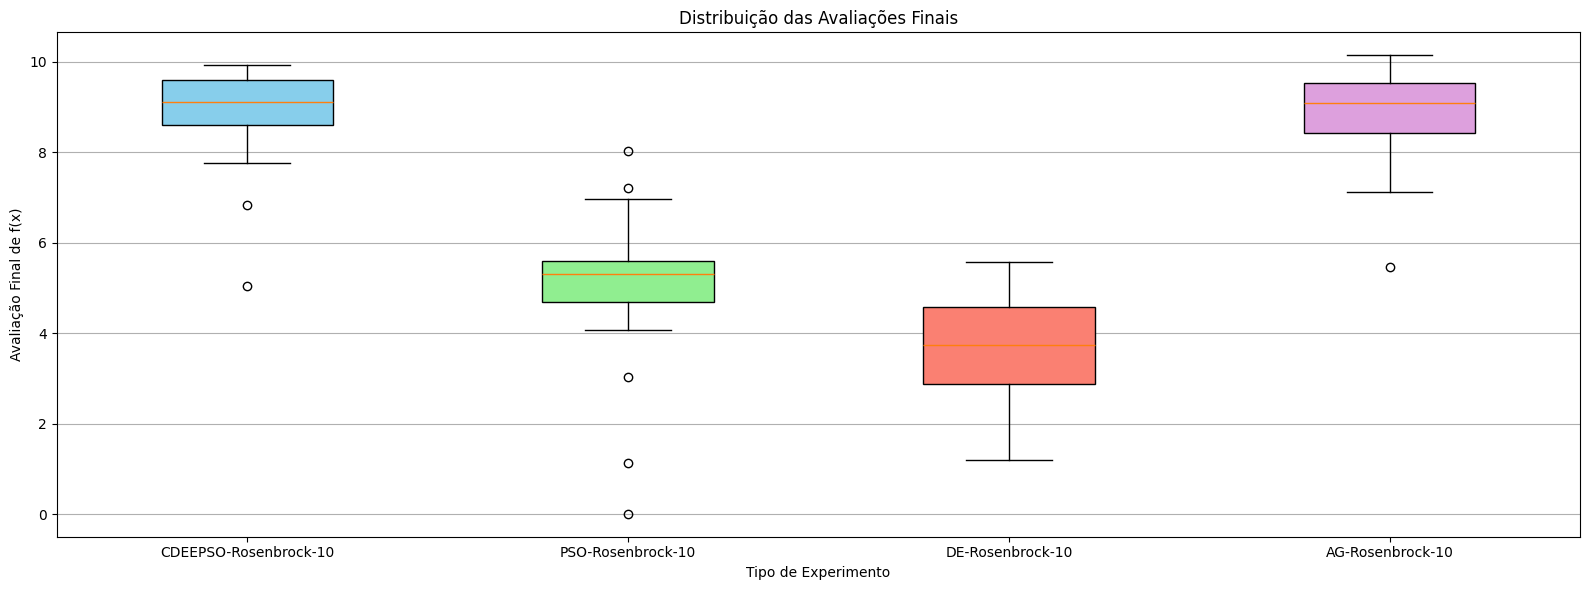

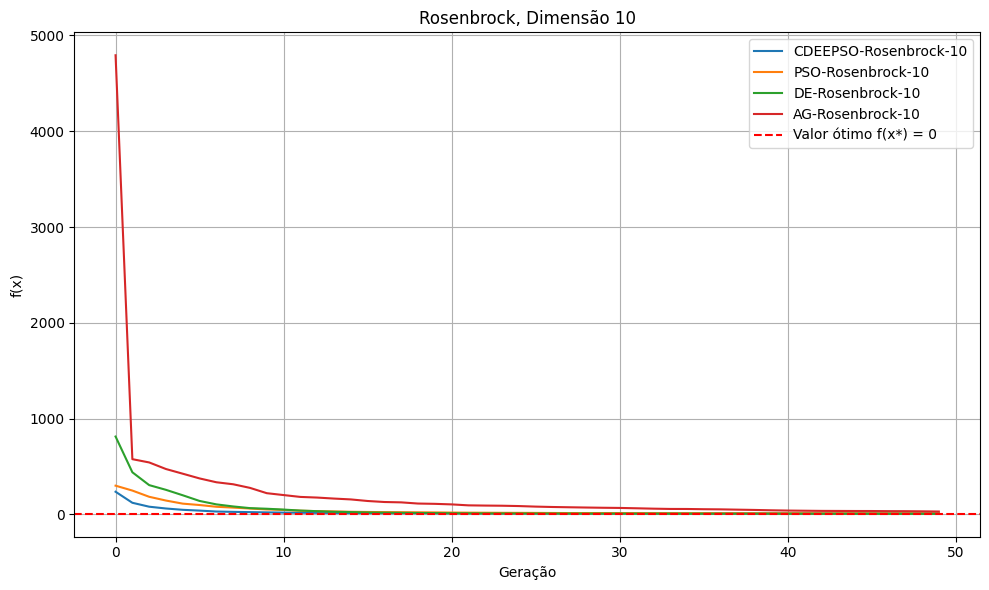

/tmp/ipython-input-10-1729042895.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(evaluations_data, labels=experiment_names, patch_artist=True)


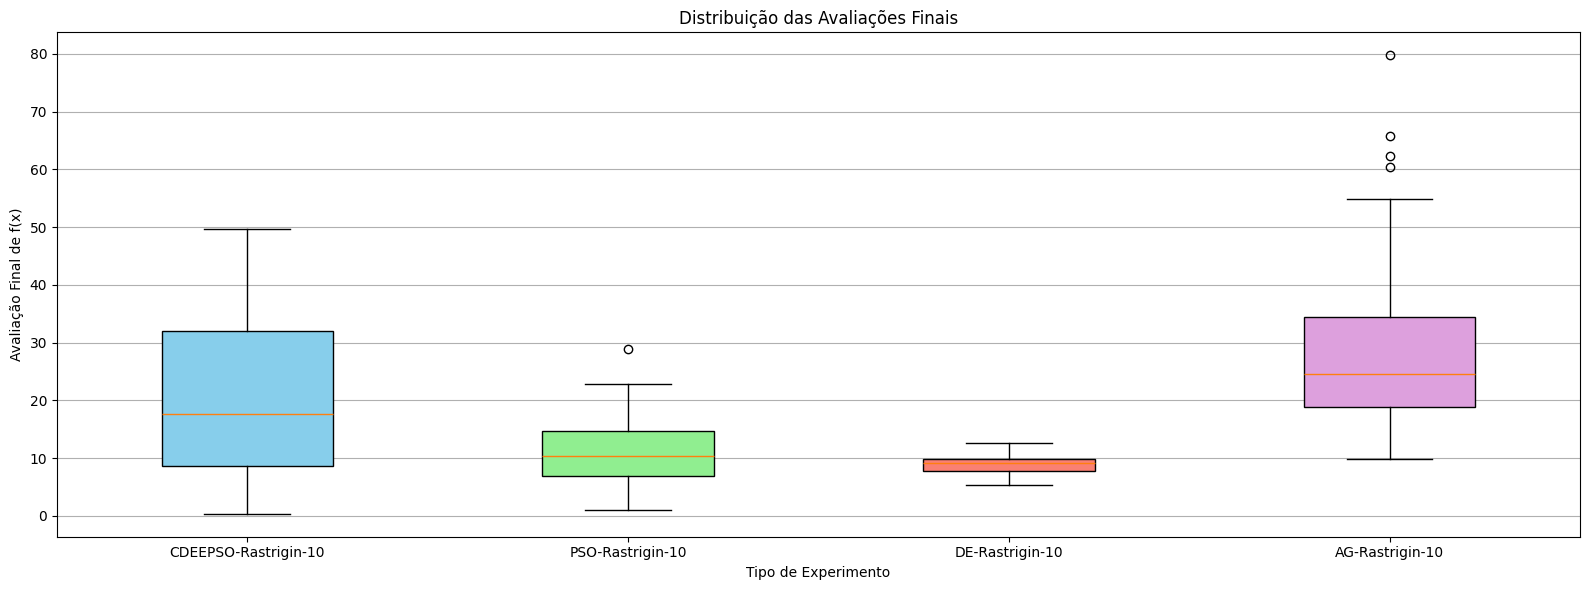

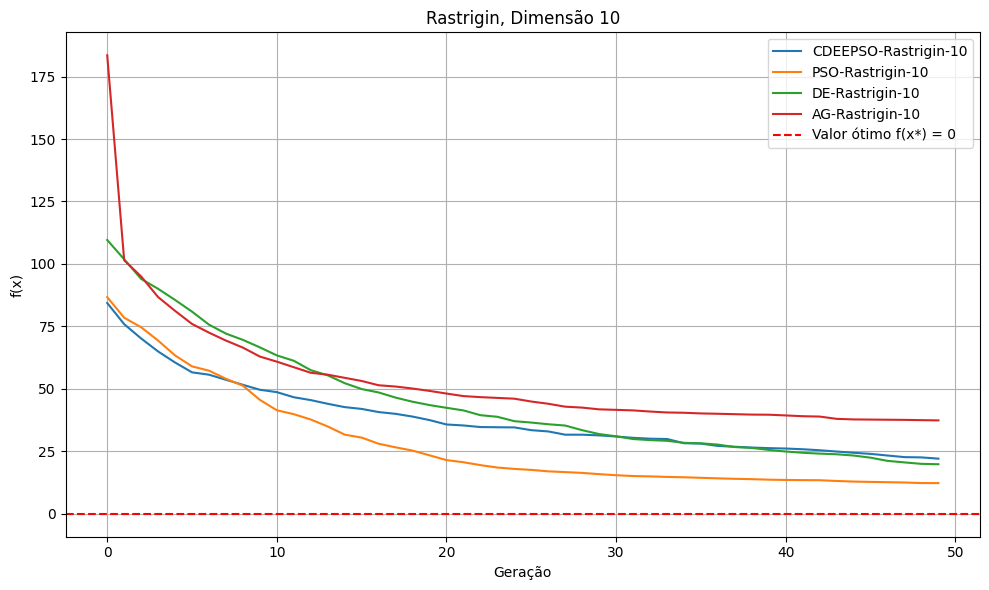

/tmp/ipython-input-10-1729042895.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(evaluations_data, labels=experiment_names, patch_artist=True)


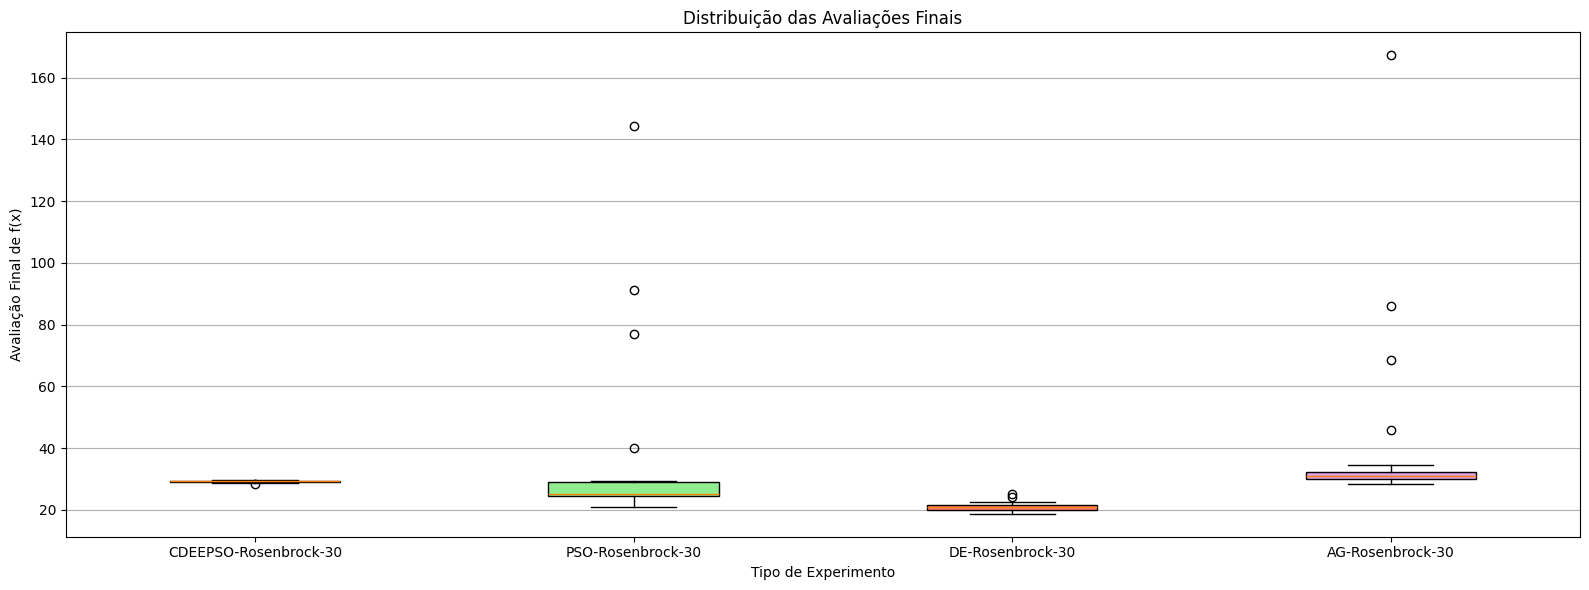

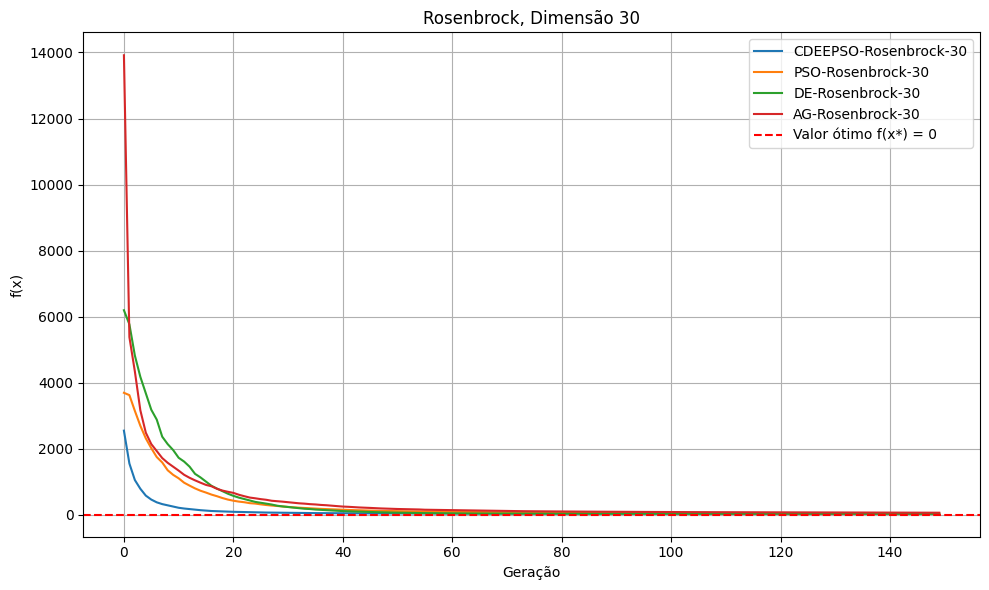

/tmp/ipython-input-10-1729042895.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(evaluations_data, labels=experiment_names, patch_artist=True)


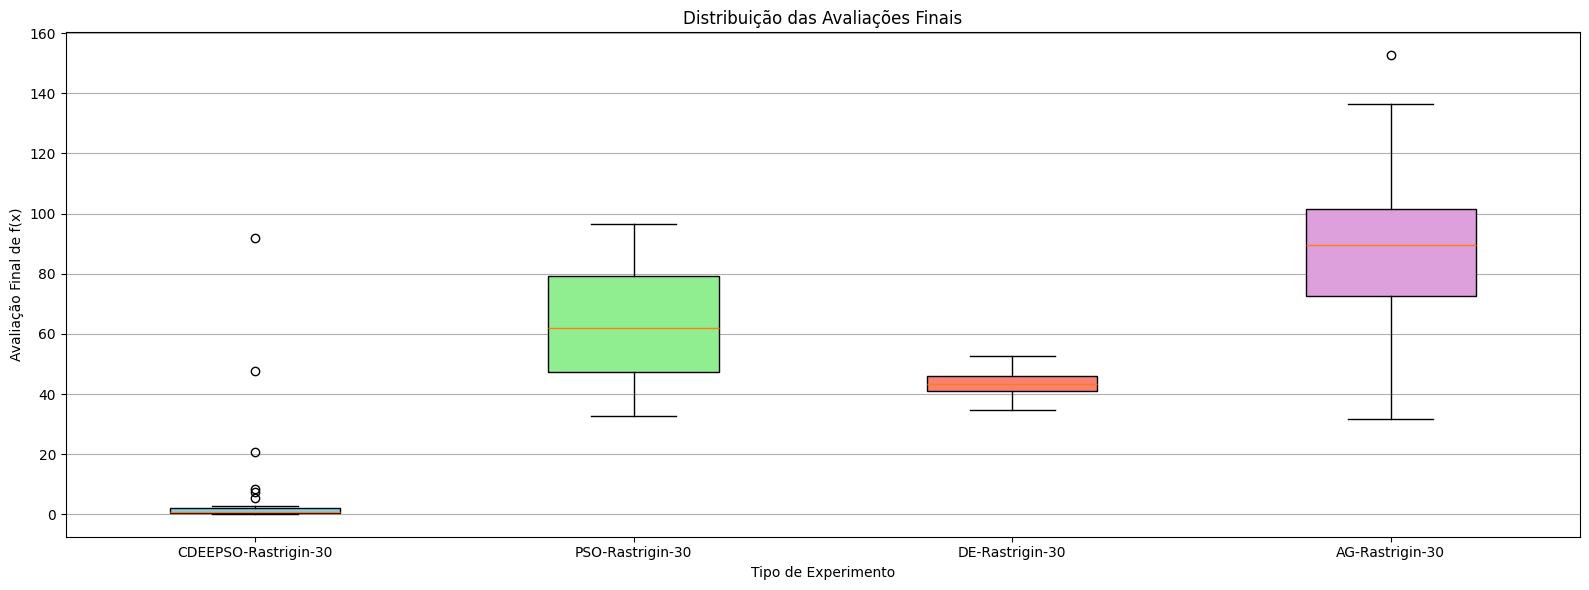

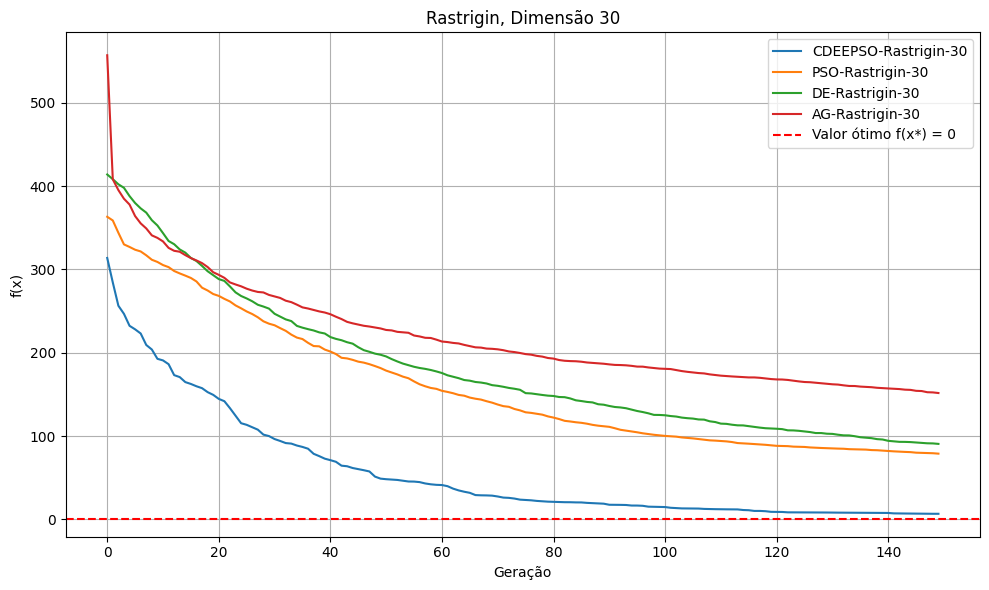

/tmp/ipython-input-10-1729042895.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(evaluations_data, labels=experiment_names, patch_artist=True)


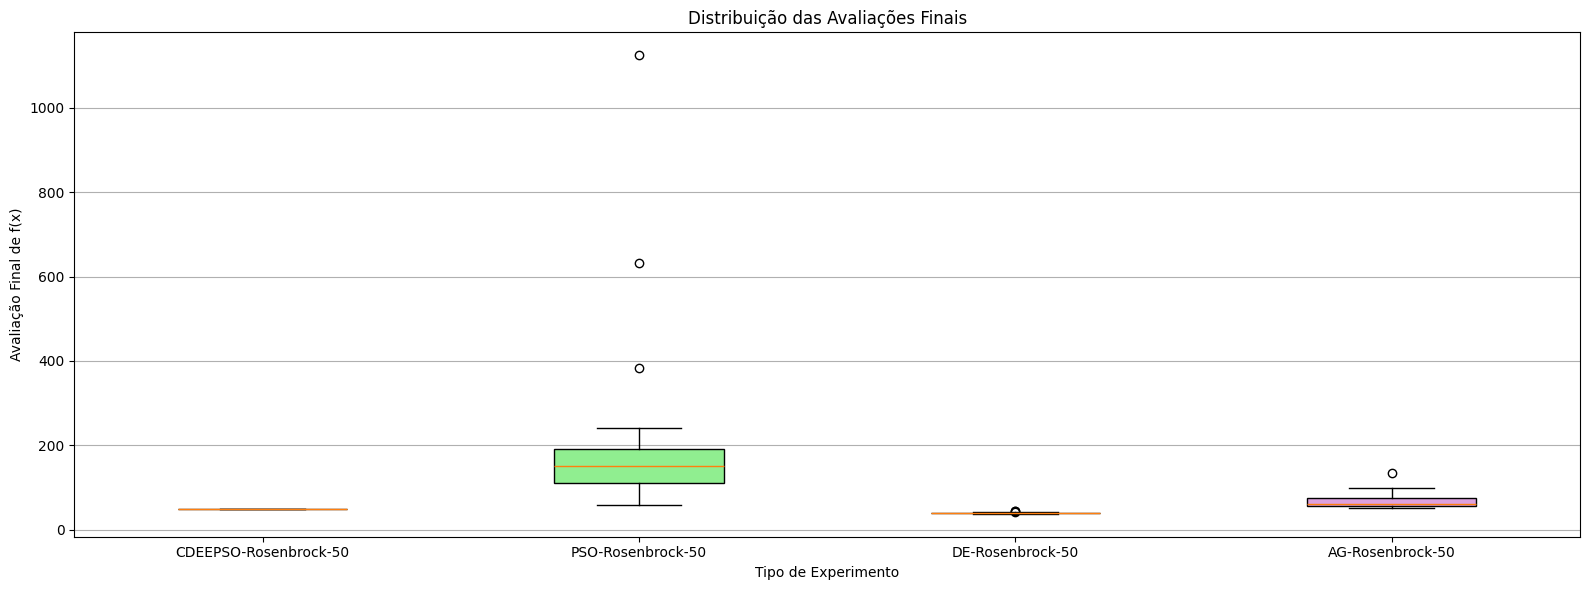

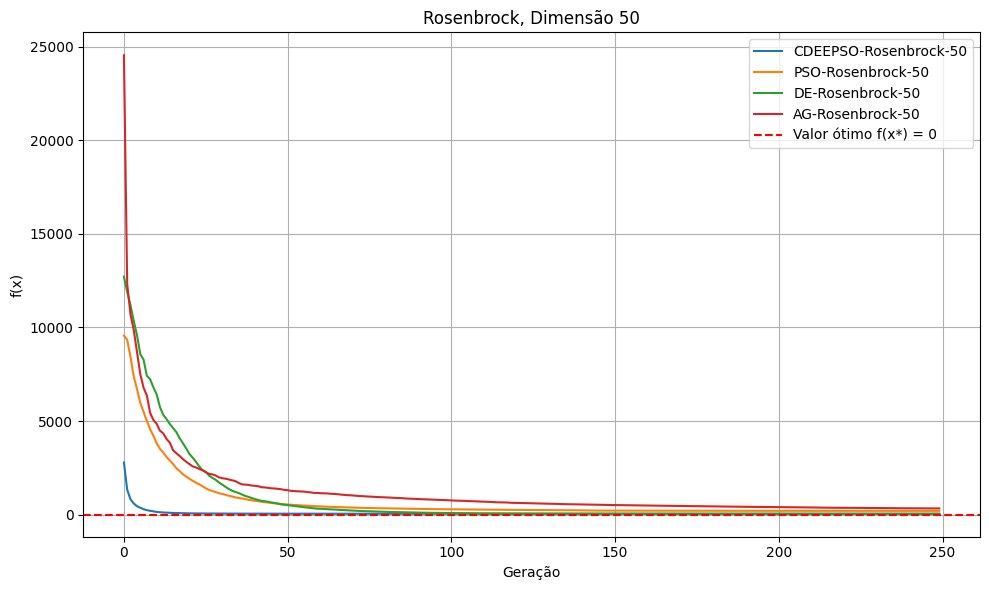

/tmp/ipython-input-10-1729042895.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(evaluations_data, labels=experiment_names, patch_artist=True)


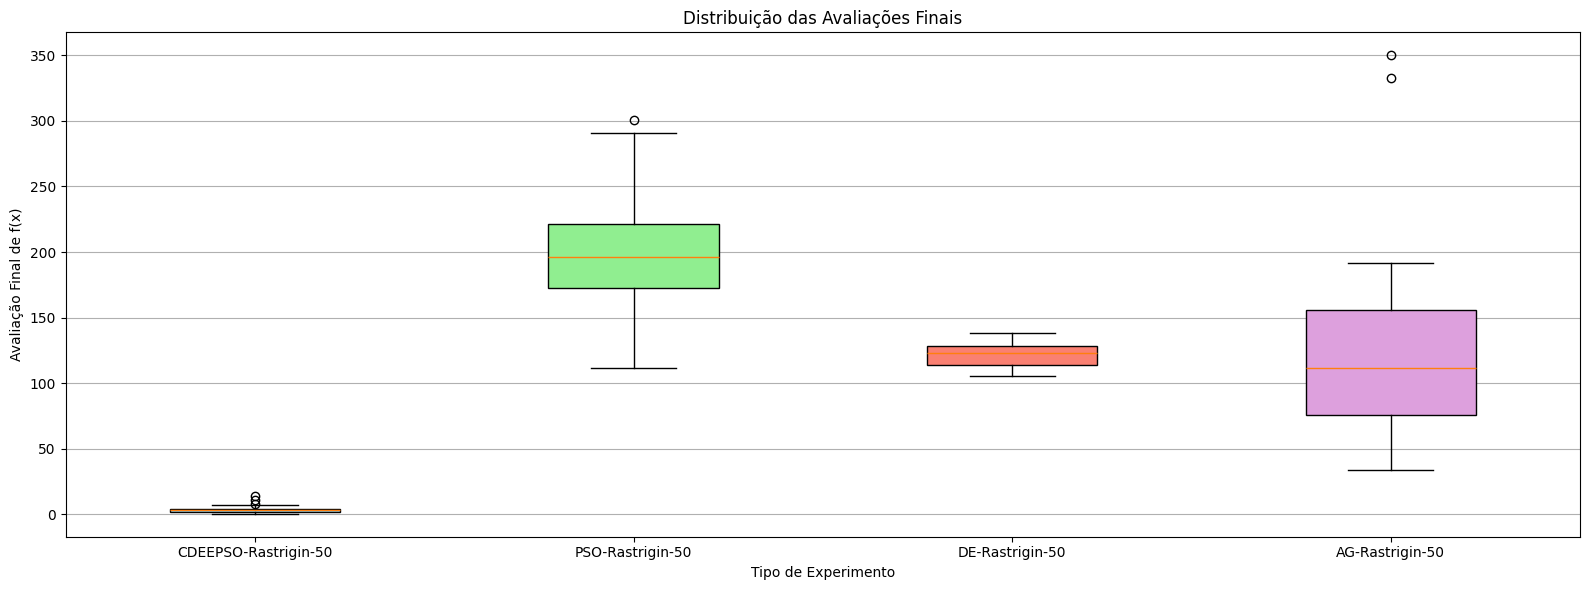

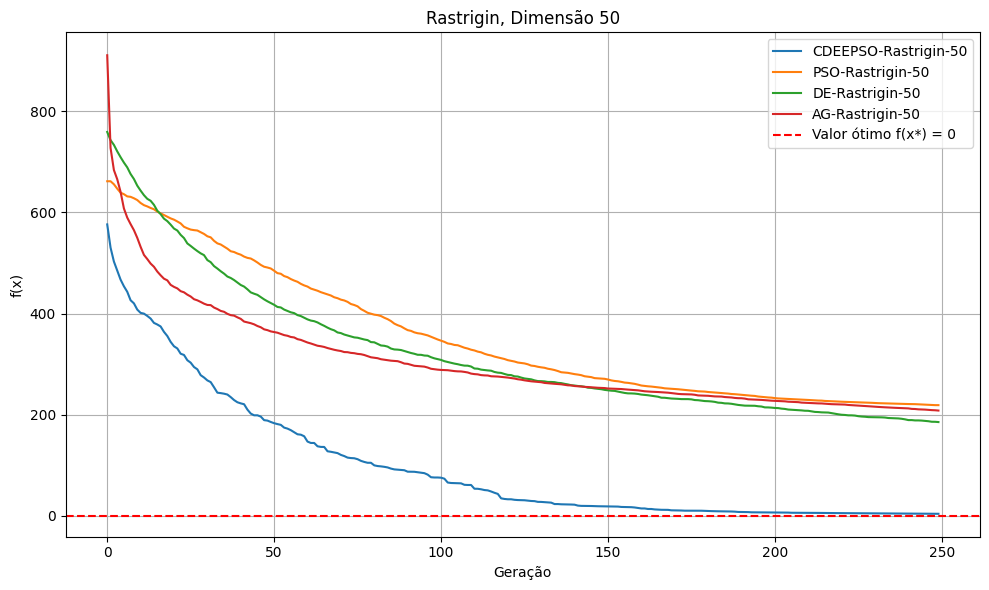

In [ ]:
for dimensao in dimensoes:
  for nome_funcao, funcao in funcoes:
    sub_curvas = {k: v for k, v in curvas.items() if f'{nome_funcao}-{dimensao}' in k}
    sub_avaliacoes = {k: v for k, v in melhores_avaliacoes_experimentos.items() if f'{nome_funcao}-{dimensao}' in k}

    plot_boxplot_evaluations(sub_avaliacoes, file_name=f'boxplot_{nome_funcao}_{dimensao}')
    plot_multiple_convergence_curves(curves_dict=sub_curvas,
                                     title=f'{nome_funcao}, Dimensão {dimensao}',
                                     file_name=f'convergence_curves_{nome_funcao}_{dimensao}',
                                     f_min=0,
                                     zoom_range=(0, 5),
                                     mode='full')

    # plot_multiple_convergence_curves(curves_dict=sub_curvas,
    #                                  title=f'{nome_funcao}, Dimensão {dimensao}',
    #                                  file_name=f'convergence_curves_{nome_funcao}_{dimensao}_zoom',
    #                                  f_min=0,
    #                                  zoom_range=(0, 5),
    #                                  mode='zoom')

In [ ]:
# plot_boxplot_evaluations(melhores_avaliacoes_experimentos, file_name='boxplot_completo')

# # melhores_avaliacoes_experimentos_incompleto = melhores_avaliacoes_experimentos.copy()
# # melhores_avaliacoes_experimentos_incompleto.pop("DE/current-to-best/1 - Sg-rand", None)
# # plot_boxplot_evaluations(melhores_avaliacoes_experimentos_incompleto, file_name='boxplot_incompleto')

# plot_multiple_convergence_curves(curves_dict=curvas,
#                                  title=f'Experimentos',
#                                  file_name=f'Experimentos_{funcao}',
#                                  f_min=0,
#                                  zoom_range=(0, 5),
#                                  mode='both')

# plot_multiple_convergence_curves(curves_dict=curvas,
#                                  title=f'Experimentos',
#                                  file_name=f'Experimentos_{funcao}_zoom',
#                                  f_min=0,
#                                  zoom_range=(0, 5),
#                                  mode='zoom')

# Gerar parâmetros tunados

In [ ]:
def gerar_objetivo_CDEEPSO(estrategia_DE, estrategia_vetor_amostrado, funcao, dimensao):
  def objetivo(trial):
    Cr = trial.suggest_float('Cr', 0.1, 0.9)
    t_mut = trial.suggest_float('t_mut', 0.1, 0.9)
    p_com = trial.suggest_float('p_com', 0.1, 0.9)
    k_mem = trial.suggest_int('k_mem', 1, 10)
    wi = trial.suggest_float('wi', 0.1, 0.9)
    wa = trial.suggest_float('wa', 0.1, 0.9)
    wc = trial.suggest_float('wc', 0.1, 0.9)

    xmin, xmax = intervalo_funcoes[nome_funcao]

    alg = C_DEEPSO(
        funcao=funcao(dimensao),
        dimensao=dimensao,
        tamanho_populacao=tamanho_populacao,
        w_i=wi,
        w_a=wa,
        w_c=wc,
        k_mem=k_mem,
        p_com=p_com,
        t_mut=t_mut,
        x_faixa=(xmin, xmax),
        Cr=Cr,
        estrategia_DE=estrategia_DE,
        estrategia_vetor_amostrado=estrategia_vetor_amostrado,
        max_avaliacoes=max_avaliacoes[dimensao]
    )

    trace_populacoes, trace_avaliacoes, trace_num_avaliacoes = alg.run()

    melhor_avaliacao = trace_avaliacoes[-1][0]

    return melhor_avaliacao

  return objetivo

def gerar_objetivo_PSO(funcao, dimensao):
  def objetivo_pso_autoral(trial):
    w = trial.suggest_float('w', 0.4, 0.9)
    c1 = trial.suggest_float('c1', 1.5, 2.5)
    c2 = trial.suggest_float('c2', 1.5, 2.5)

    xmin, xmax = intervalo_funcoes[nome_funcao]

    alg = Nuvem_de_Particulas(
        funcao=funcao(dimensao),
        dimensao=dimensao,
        faixa=(xmin, xmax),
        tamanho_populacao=tamanho_populacao,
        max_avaliacoes=max_avaliacoes[dimensao],
        c1=c1,
        c2=c2,
        w=w
    )

    trace_populacoes, trace_avaliacoes, trace_num_avaliacoes = alg.run()

    melhor_avaliacao = trace_avaliacoes[-1][0]

    return melhor_avaliacao

  return objetivo_pso_autoral

def gerar_objetivo_DE(estrategia_DE, funcao, dimensao):
  def objetivo_de(trial):
    Cr = trial.suggest_float('Cr', 0.1, 0.9)
    F = trial.suggest_float('F', 0.1, 0.9)

    xmin, xmax = intervalo_funcoes[nome_funcao]

    alg = Evolucao_Diferencial(
        funcao=funcao(dimensao),
        dimensao=dimensao,
        NP=tamanho_populacao,
        faixa=(xmin, xmax),
        Cr=Cr,
        F=F,
        max_avaliacoes=max_avaliacoes[dimensao],
        estrategia=estrategia_DE
    )

    trace_populacoes, trace_avaliacoes, trace_num_avaliacoes = alg.run()

    melhor_avaliacao = trace_avaliacoes[-1][0]

    return melhor_avaliacao

  return objetivo_de

def gerar_objetivo_AG(funcao, dimensao):
  def objetivo_ag(trial):
    taxa_recombinacao = trial.suggest_float('taxa_recombinacao', 0.1, 0.9)
    taxa_mutacao = trial.suggest_float('taxa_mutacao', 0.1, 0.9)
    tamanho_elite = trial.suggest_int('tamanho_elite', 1, 10)
    tamanho_torneios = trial.suggest_int('tamanho_torneios', 2, 10)
    variancia_mutacao = trial.suggest_float('variancia_mutacao', 0.1, 0.9)

    xmin, xmax = intervalo_funcoes[nome_funcao]

    alg = Algoritimo_Genetico(
        funcao=funcao(dimensao),
        dimensao=dimensao,
        tamanho_populacao=tamanho_populacao,
        faixa=(xmin, xmax),
        taxa_recombinacao=taxa_recombinacao,
        taxa_mutacao=taxa_mutacao,
        tamanho_elite=tamanho_elite,
        tamanho_torneios=tamanho_torneios,
        variancia_mutacao=variancia_mutacao,
        max_avaliacoes=max_avaliacoes[dimensao]
    )

    trace_populacoes, trace_avaliacoes, trace_num_avaliacoes = alg.run()

    melhor_avaliacao = trace_avaliacoes[-1][0]

    return melhor_avaliacao

  return objetivo_ag

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study()

for dimensao in dimensoes:
  for nome_funcao, funcao in funcoes:
    print(f"Função: {nome_funcao}, Dimensão: {dimensao}")

    estrategia_DE_CDEEPSO = parametros_experimentos_CDEEPSO['estrategia_DE']
    estrategia_vetor_amostrado = parametros_experimentos_CDEEPSO['estrategia_vetor_amostrado']

    estrategia_DE = "DE/current-to-best/1/bin"

    # study = optuna.create_study()
    # study.optimize(gerar_objetivo_CDEEPSO(estrategia_DE_CDEEPSO, estrategia_vetor_amostrado, funcao, dimensao), n_trials=100)
    # print('CDEEPSO')
    # print(study.best_params)

    # study = optuna.create_study()
    # study.optimize(gerar_objetivo_PSO(funcao, dimensao), n_trials=100)
    # print('PSO')
    # print(study.best_params)

    # study = optuna.create_study()
    # study.optimize(gerar_objetivo_DE(estrategia_DE, funcao, dimensao), n_trials=100)
    # print('DE')
    # print(study.best_params)

    # study = optuna.create_study()
    # study.optimize(gerar_objetivo_AG(funcao, dimensao), n_trials=100)
    # print('AG')
    # print(study.best_params)

# Inferência

In [ ]:
stat, p_value = stats.friedmanchisquare()

print(f"Estatística de teste de Friedman: {stat:.4f}")
print(f"P-valor: {p_value:.4f}")

if p_value < 0.05:
    print("\nHá uma diferença estatisticamente significativa entre o desempenho dos algoritmos.")
    print("Um teste post-hoc (como Nemenyi ou Bonferroni-Dunn) é necessário para comparações par a par.")
else:
    print("\nNão há evidências de uma diferença estatisticamente significativa entre o desempenho dos algoritmos.")

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

def gerar_heatmap_pvalores(melhores_avaliacoes_experimentos):
    algoritmos_comp = ['DE', 'PSO', 'AG']  # comparações contra CDEEPSO
    funcoes = ['Rosenbrock', 'Rastrigin']
    dimensoes = [10, 30, 50]

    # Montar matriz para armazenar p-valores: linhas=categorias, colunas=algoritmos
    cenarios = [f'{f}-{d}' for f in funcoes for d in dimensoes]
    pvalores = np.full((len(cenarios), len(algoritmos_comp)), np.nan)

    for i, func_dim in enumerate(cenarios):
        func, dim = func_dim.split('-')
        cdeepso_key = f'CDEEPSO-{func}-{dim}'
        if cdeepso_key not in melhores_avaliacoes_experimentos:
            continue
        cdeepso_data = melhores_avaliacoes_experimentos[cdeepso_key]

        for j, alg in enumerate(algoritmos_comp):
            alg_key = f'{alg}-{func}-{dim}'
            if alg_key not in melhores_avaliacoes_experimentos:
                continue
            alg_data = melhores_avaliacoes_experimentos[alg_key]

            # Verificar se os tamanhos são iguais para rodar wilcoxon
            if len(cdeepso_data) == len(alg_data):
                try:
                    _, p = wilcoxon(cdeepso_data, alg_data)
                    pvalores[i, j] = p
                except ValueError:
                    pvalores[i, j] = np.nan

    # Plotar heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        pvalores,
        annot=True,
        fmt=".4f",
        xticklabels=algoritmos_comp,
        yticklabels=cenarios,
        cmap='coolwarm_r',
        cbar_kws={'label': 'p-valor'}
    )
    plt.title('Heatmap dos p-valores Wilcoxon (CDEEPSO vs outros)')
    plt.xlabel('Algoritmos comparados')
    plt.ylabel('Cenários (Função-Dimensão)')
    plt.tight_layout()
    plt.show()

In [ ]:
def realizar_teste_friedman(caminho_arquivo):
    with open(caminho_arquivo, 'r') as f:
        dados_completos = json.load(f)

    cenarios = defaultdict(dict)

    for chave, valores in dados_completos.items():
      algoritmo, funcao, dimensao = chave.split('-')
      cenarios[(funcao, dimensao)][algoritmo] = valores

    print("Resultados do Teste de Friedman:\n")

    for (funcao, dimensao), dados_cenario in cenarios.items():
        print(f"Cenário: {funcao} - {dimensao}")

        dados_para_teste = list(dados_cenario.values())

        stat, p_valor = scipy.stats.friedmanchisquare(*dados_para_teste)

        print(f"  Estatística do teste: {stat:.2f}")
        print(f"  p-valor: {p_valor:e}")
        print("-" * 30)

nome_arquivo = 'melhores_avaliacoes_experimentos.json'

realizar_teste_friedman(nome_arquivo)

Resultados do Teste de Friedman:

Cenário: Rosenbrock - 10
  Estatística do teste: 73.72
  p-valor: 6.814183e-16
------------------------------
Cenário: Rastrigin - 10
  Estatística do teste: 38.12
  p-valor: 2.665868e-08
------------------------------
Cenário: Rosenbrock - 30
  Estatística do teste: 66.28
  p-valor: 2.670068e-14
------------------------------
Cenário: Rastrigin - 30
  Estatística do teste: 66.32
  p-valor: 2.617964e-14
------------------------------
Cenário: Rosenbrock - 50
  Estatística do teste: 87.76
  p-valor: 6.631522e-19
------------------------------
Cenário: Rastrigin - 50
  Estatística do teste: 72.76
  p-valor: 1.094217e-15
------------------------------


In [ ]:
def perform_nemenyi_test(caminho_arquivo):
  with open(caminho_arquivo, 'r') as f:
    dados_completos = json.load(f)

  cenarios = defaultdict(dict)
  # Organize data by scenario
  for chave, valores in dados_completos.items():
      algoritmo, funcao, dimensao = chave.split('-')
      cenarios[(funcao, dimensao)][algoritmo] = valores

  results = {}

  for (funcao, dimensao), dados_cenario in cenarios.items():
      print(f"Performing Nemenyi test for scenario: {funcao} - {dimensao}")

      # Convert the dictionary for the current scenario into a list of lists
      # Ensure all lists have the same length for the test
      algoritmos = list(dados_cenario.keys())
      data_lists = list(dados_cenario.values())

      # Find the minimum length and truncate lists if necessary
      min_len = min(len(lst) for lst in data_lists)
      truncated_data = [lst[:min_len] for lst in data_lists]

      if not truncated_data or len(truncated_data) < 2:
          print(f"  Skipping scenario {funcao}-{dimensao}: Not enough data or algorithms.")
          continue

      # Perform the Nemenyi test
      try:
          # Transpose the data so each row is an algorithm's results
          data_transposed = np.array(truncated_data).T
          nemenyi_result = sp.posthoc_nemenyi_friedman(data_transposed)

          # Rename columns and index for clarity
          nemenyi_result.columns = algoritmos
          nemenyi_result.index = algoritmos

          results[f'{funcao}-{dimensao}'] = nemenyi_result
          print(f"  Nemenyi test for {funcao}-{dimensao} completed.")
      except Exception as e:
          print(f"  Error performing Nemenyi test for {funcao}-{dimensao}: {e}")
          traceback.print_exc() # Print traceback for debugging

      print("-" * 30)

  return results

nome_arquivo = 'melhores_avaliacoes_experimentos.json'

nemenyi_results = perform_nemenyi_test(nome_arquivo)

# Print the results
for scenario, result_df in nemenyi_results.items():
    print(f"\nNemenyi Test Results for Scenario: {scenario}")
    print(result_df)
    print("\n" + "="*50 + "\n")

Performing Nemenyi test for scenario: Rosenbrock - 10
  Nemenyi test for Rosenbrock-10 completed.
------------------------------
Performing Nemenyi test for scenario: Rastrigin - 10
  Nemenyi test for Rastrigin-10 completed.
------------------------------
Performing Nemenyi test for scenario: Rosenbrock - 30
  Nemenyi test for Rosenbrock-30 completed.
------------------------------
Performing Nemenyi test for scenario: Rastrigin - 30
  Nemenyi test for Rastrigin-30 completed.
------------------------------
Performing Nemenyi test for scenario: Rosenbrock - 50
  Nemenyi test for Rosenbrock-50 completed.
------------------------------
Performing Nemenyi test for scenario: Rastrigin - 50
  Nemenyi test for Rastrigin-50 completed.
------------------------------

Nemenyi Test Results for Scenario: Rosenbrock-10
              CDEEPSO           PSO            DE            AG
CDEEPSO  1.000000e+00  6.925594e-07  3.612555e-12  8.971101e-01
PSO      6.925594e-07  1.000000e+00  2.279775e-01  2.5